In [10]:
#Generate data
import numpy as np

n = 100
synthetic_data = np.empty((n*n,3))

x = np.linspace(1,20,n)
y = np.linspace(10,40,n)

for i in range(n):
    for j in range(n):
        synthetic_data[i+j*n-1,:] = np.array([x[i],y[j],(x[i]-10.0)**2-(y[j]-15)**2])

#Shuffle contents
np.random.shuffle(synthetic_data)

<IPython.core.display.Javascript object>


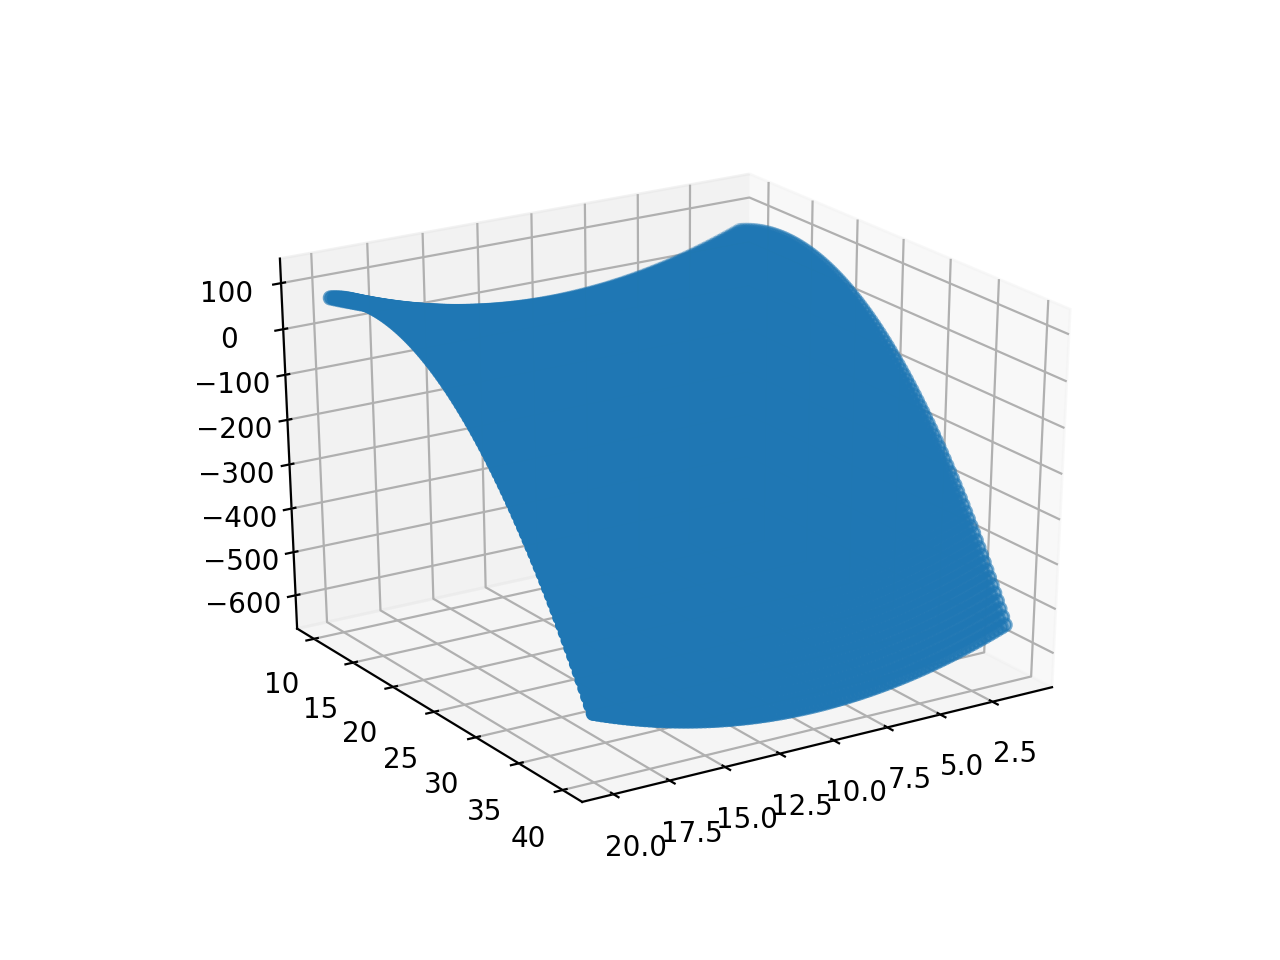

In [11]:
#Graph this data to be sure it is what we want
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import numpy as np
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(synthetic_data[:,0], synthetic_data[:,1], synthetic_data[:,2])

In [23]:
#Helper functions
def normalise(x):
    """Convert values to range 0-1"""
    x_h = (x - x.min())*1.0 / (x.max() - x.min())
    
    return x_h, x.min(), x.max()

def un_normalise(x_h, x_min, x_max):
    """Convert values from range 0-1 back to normal"""
    x = (x_max-x_min)*x_h + x_min
    
    return x

In [32]:
#Now let's try with an autoencoder
import tensorflow as tf
#Prepare for training and validation with a 70:30 split
split_size = int(synthetic_data.shape[0]*0.7)

#Normalise values
x, x_min, x_max = normalise(synthetic_data)
#Remember that for autoencoders we don't need to have any targets since the values themselves are the targets
train_x, val_x = x[:split_size], x[split_size:]

#Most online examples use batch training but we are using a small synthetic dataset so online will suffice